# PUBG Finish Placement Prediction

### Members
#### Yan Sun          yas108@ucsd.edu      A53240727
#### Xufan Xiong      x7xiong@ucsd.edu     A53256057

<img src="FinalRun/PUBG Inlay.jpg" alt="Drawing" style="width: 500px;"/>

### Motivation

Recently, the battle royale-style game has become a very popular online game. One of the most famous game is called PlayerUnknown's BattleGrounds (PUBG). At beginning of each play, nearly 100 people parachute onto an island without any equipment. In order to win the game, you need to scavenge for weapons and available equipment to eliminate the other people and survive to the end.

Hence, if you want to see ‘Winner Winner Chicken Dinner!’ on your display, it’s very esscnetial to make some reasonable strategies based on actual condition. For example, a suitable location of parachuting can help you collect the equipment faster, the path you escape from the continuously shrinking blue circle (out of the circle players will get damage continuously until they die) can help you avoid some dangerous enemies and find a suitable location to hide in the last circle is helpful get the ‘Chicken Dinner’.

Based on these reasons, collect the PUBG’s data and analyze it is a meaningful work to help the player to survive at last. Kaggle hold an interesting competition which try to predict the final ranking percnetile based on the data collected through the PUBG developer API.  This dataset has 28 features such as, number of enemy player killed, duration of the match, and so on. According to these data, we try to find the best model to predict the final percentile winning placement.

### Objective

To sum up, given previous game record of players statistical data and ranking in training data, we need to train a model predict the ranking of the player in testing set based on their statitical data.

# Description of features:

There are many features existed in the given dataset, which represente the player statistical data in the game.

* DBNOs - Number of enemy players knocked.

* assists - Number of enemy players this player damaged that were killed by teammates.

* boosts - Number of boost items used.

* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

* headshotKills - Number of enemy players killed with headshots.

* heals - Number of healing items used.

* Id - Player’s Id

* killPlace - Ranking in match of number of enemy players killed.

* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

* killStreaks - Max number of enemy players killed in a short amount of time.

* kills - Number of enemy players killed.

* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

* matchDuration - Duration of match in seconds.

* matchId - ID to identify match. There are no matches that are in both the training and testing set.

* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and  “squad-fpp”; other modes are from events or custom matches.

* rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

* revives - Number of times this player revived teammates.

* rideDistance - Total distance traveled in vehicles measured in meters.

* roadKills - Number of kills while in a vehicle.

* swimDistance - Total distance traveled by swimming measured in meters.

* teamKills - Number of times this player killed a teammate.

* vehicleDestroys - Number of vehicles destroyed.

* walkDistance - Total distance traveled on foot measured in meters.

* weaponsAcquired - Number of weapons picked up.

* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

* numGroups - Number of groups we have data for in the match.

* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.


In [1]:
## Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import gc, sys

## Auxiliary Functions

reduceMemory function try to reduce memory usage when we import the large data.

In [2]:
def reduceMemory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage. 
        # Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage       
    """
    import numpy as np

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

visulize function is used to visulize some features of the data.

In [3]:
def visualize(col_name, num_bin=10):
    '''
    Function for visualization
    '''
    title_name = col_name[0].upper() + col_name[1:]
    f, ax = plt.subplots()
    plt.xlabel(title_name)
    plt.ylabel('log Count')
    ax.set_yscale('log')
    df_train.hist(column=col_name,ax=ax,bins=num_bin)
    plt.title('Histogram of ' + title_name)
    tmp = df_train[col_name].value_counts().sort_values(ascending=False)

    print('Min value of ' + title_name + ' is: ',min(tmp.index))
    print('Max value of ' + title_name + ' is: ',max(tmp.index))

Buildfeature function is used to do some feature engineering.

In [4]:
def BuildFeature(is_train=True):
    '''
    Function for feature engineering
    is_train incicates whether the train set or the test set is processed
    '''
    y = None
    test_idx = None
    
    if is_train: 
        print("Reading train.csv")
        df = pd.read_csv('../input/train_V2.csv')           
        df = df[df['maxPlace'] > 1]
    else:
        print("Reading test.csv")
        df = pd.read_csv('../input/test_V2.csv')
        test_idx = df.Id
    
    # Reduce the memory usage
    df = reduce_mem_usage(df)
    
    print("Delete Unuseful Columns")
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")  
    
    if is_train: 
        print("Read Labels")
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("Read Group mean features")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    if is_train:
        df_out = agg.reset_index()[['matchId','groupId']]
    else:
        df_out = df[['matchId','groupId']]
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])

    print("Read Group max features")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("Read Group min features")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("Read Group size features")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("Read Match mean features")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    print("Read Match size features")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)
    X = df_out
    feature_names = list(df_out.columns)
    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y, feature_names, test_idx

## Preprocessing Data

If you want to reproduce our result, please go to Kaggle competition and create a kernel for access to data.

PUBG competition: https://www.kaggle.com/c/pubg-finish-placement-prediction

In [6]:
develop_mode = False
if develop_mode:
    df_train = reduceMemory(pd.read_csv('../input/train_V2.csv', nrows=5000))
    df_test = reduceMemory(pd.read_csv('../input/test_V2.csv'))
else:
    df_train = reduceMemory(pd.read_csv('../input/train_V2.csv'))
    df_test = reduceMemory(pd.read_csv('../input/test_V2.csv'))

In [7]:
print('The sizes of the datasets are:')
print('Training Dataset: ', df_train.shape)
print('Testing Dataset: ', df_test.shape)

The sizes of the datasets are:
Training Dataset:  (4446966, 29)
Testing Dataset:  (1934174, 28)


In [8]:
# Get Sample Data
df_train.head(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,-1,0,0.000000,0,0.000000,0,0,244.7500,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.500000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,1484,0,0.004501,0,11.039062,0,0,1434.0000,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,1491,0,0.000000,0,0.000000,0,0,161.7500,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.906250,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,1408,0,0.000000,0,0.000000,0,0,202.7500,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,1560,0,0.000000,0,0.000000,0,0,49.7500,2,0,0.187500
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000000,1,1,0,44,0,1,1,18.43750,1395,squad-fpp,28,28,1418,0,0.000000,0,0.000000,0,0,34.6875,1,0,0.036987
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000000,0,0,0,96,1262,0,0,0.00000,1316,squad-fpp,28,28,-1,0,0.000000,0,0.000000,0,0,13.5000,1,1497,0.000000
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.539062,0,0,0,48,1000,0,0,0.00000,1967,solo-fpp,96,92,-1,0,2004.000000,0,0.000000,0,0,1089.0000,6,1500,0.736816
8,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.593750,0,0,0,64,0,0,0,0.00000,1375,squad,28,27,1493,0,0.000000,0,0.000000,0,0,800.0000,4,0,0.370361
9,e5bb5a43587253,759bb6f7514fd2,3d3031c795305b,0,0,37.281250,0,0,0,74,0,0,0,0.00000,1930,squad,29,27,1349,0,0.000000,0,0.000000,0,0,65.6875,1,0,0.214355


##### Player Group Analysis

Same matchId indicates that these records are generated from one match. With the same matchId, same groupId means that these records are obtained from players of same team in double play mode or squad mode.

In [9]:
group_tmp = df_train[df_train['matchId']=='df014fbee741c6']['groupId'].value_counts().sort_values(ascending=False)

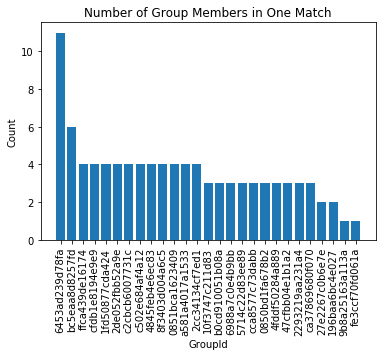

Min number of group members is:  1
Max number of group members is:  11


In [10]:
plt.figure()
plt.bar(group_tmp.index,group_tmp.values)
plt.xlabel('GroupId')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Number of Group Members in One Match')
plt.show()

print('Min number of group members is: ',min(group_tmp.values))
print('Max number of group members is: ',max(group_tmp.values))

###### Insights:

Typically, the number of members each group should be 1, 2, 3 or 4. However, groups that have more than 4 people also occurred, which may be caused by the disconnect and reconnection during the game. It is also possible that some matches are zombie mode where more than 4 people can build a team to play as zombies to attack other humans.

##### Assists Analysis

Assists in the match means that the player contributes damage to the killed enemy but he/she is not the player that make the last attack to kill that enemy. Once the contribution is made and the enemy is killed by other player, the count of assists will plus one.

Min value of Assists is:  0
Max value of Assists is:  22


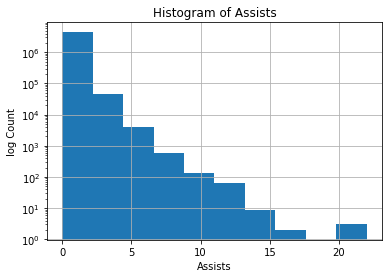

In [11]:
visualize('assists')

###### Insights:

The number of players that have fewer assists tend to be more than ones that have larger times of assists.

This is reseaonable since only a portion of player who is highly skilled at this game and can assist in attacking enemies at that moment then they are more easilt to get many assists.

##### RoadKills Analysis

RoadKills is the count of killing enemyies when the player is in a vehicle.

Min value of RoadKills is:  0
Max value of RoadKills is:  18


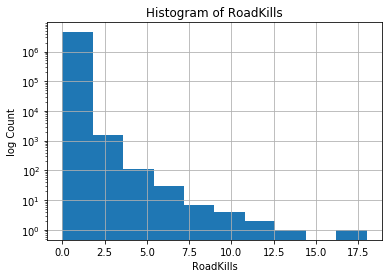

In [12]:
visualize('roadKills')

###### Insights:

The distribution of roadKills is also reasonable since only players who have high shooting accuracy could make non-zero roadKill.

In addition, a good driver within the group is also a prerequisite for other teammates to kill others while riding in vehicles.

##### KillStreaks Analysis

KillStreaks is the count of killing enemies continuously in a small range of time.

Min value of KillStreaks is:  0
Max value of KillStreaks is:  20


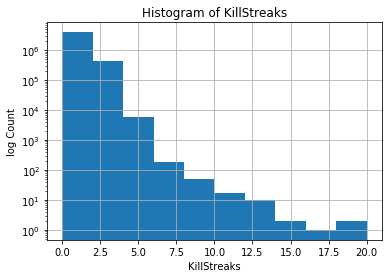

In [13]:
visualize('killStreaks')

###### Insights:

It is very hard to get a high value of killStreaks since it has been hard to find many enemies continuously within a small range of time in the large map.

However, then higher value of killStreaks could happen.

For example, at the very beginning players need to decide where would they parachute based on the flight path. In the map, there are some cities that have copious resources (weapons, ammunition, heal items and equipment). 

Players tend to parachute on these places so that several group of players would meet with in one city, where the large value of killStreaks would happen.

##### TeamKills Analysis

TeamKills indicates the count of a player killing teammates.

Min value of TeamKills is:  0
Max value of TeamKills is:  12


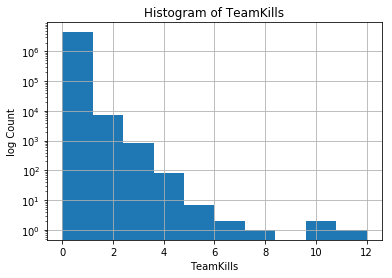

In [14]:
visualize('teamKills')

###### Insights:

TeamKills could happen when players kill their teammates. This could happen for several reasons:

* Players could kill their teammates by accident such as throwing grenades at the wrong place.

* Players disconnect from the match. Teammates kill them to avoid enemies get their weapons and equipment.

* Players could kill their teammates because they behave badly.

* Players could kill their teammates just for fun.

##### LongestKill Analysis

LongestKill is the longest distance for the distance between a player and the enemy killed by him. 

Min value of LongestKill is:  0.0
Max value of LongestKill is:  1094.0


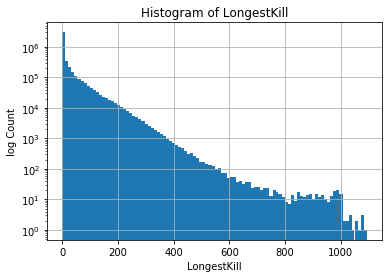

In [15]:
visualize('longestKill',num_bin=100)

###### Insights:

There are many types of weapons exist in the game and then there are many methods to kill enemies:

* If players kill enemies by punching or using knife, the killing distance will be short.

* If players kill enemies by using machine gun and automatic rifle, the killing distance could be comparably longer generally.

* If players kill enemies by using sniper rifle, the killing distance could be very long.

These are the reasons why the killing distance has such distribution.

For the distribution in the range between 800 meters and 1000 meters, the curve is plain, which is probable that there exist a group of players who is specialized in playing as a sniper.

##### Weapons Acquired Analysis

There are many types of weapons exist in this game. Players need to search them and then they can use them for battle. Weapons Acquired indicates the number of weapons each player acquired per match.

Min value of WeaponsAcquired is:  0
Max value of WeaponsAcquired is:  236


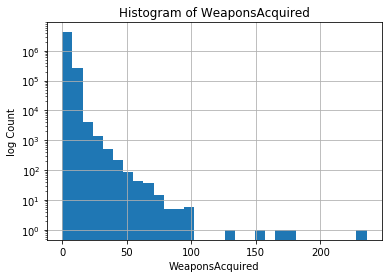

In [16]:
visualize('weaponsAcquired',num_bin=30)

###### Insight:
* The weapon acquired of every gamer in each match is also an important feature to predict the final placement. 

* Since if the gamers collect very few weapon means they are killed very quickly. 

* If the gamers collect more weapons, it means they can survive longer or they kill many enemies.

##### HeadShot Kill Analysis

If a player kill enemies by shooting their head, these kills will be counted as HeadShot Kills, which will make more damage than shooting other part of enemy's body.

Min value of HeadshotKills is:  0
Max value of HeadshotKills is:  64


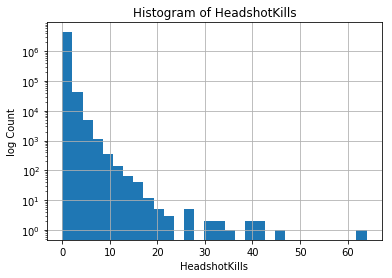

In [17]:
visualize('headshotKills',num_bin=30)

##### DBNO Analysis

DBNO indeicates the number of enemies that the player knocks down. Knocking down enemies means making damage to them and their health points go down to zero. After that, the enemies can only crawl and will not be able to fight anymore except that their teammates cure them. If the player continue making damage to the knocked enemies and make their health points zero again, the enemies will be killed and eliminated.

Min value of DBNOs is:  0
Max value of DBNOs is:  53


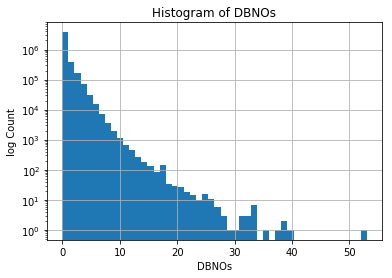

In [18]:
visualize('DBNOs',num_bin=50)

##### Boost and Heal Analysis

Boost indicates the number of times of using boosting items such as energy drink, which will help increase the moving speed and recover the health point slowly. Heal indicates using healing items such as medical bandage, which will recover the health point instantly after waiting for casting time for several seconds.

Min value of Boosts is:  0
Max value of Boosts is:  33


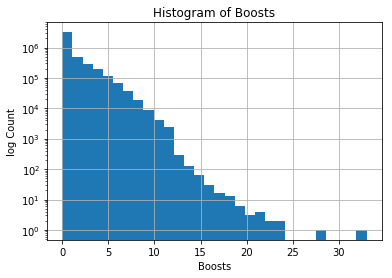

In [19]:
visualize('boosts',num_bin=30)

Min value of Heals is:  0
Max value of Heals is:  80


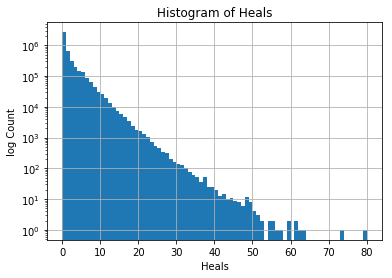

In [20]:
visualize('heals',num_bin=80)

##### DamageDealt Analysis

DamageDealt indicates the total amount of damage that player makes. The damage that players hurt themselves (such as throwing buring bottle but accidently hurt themselves) is not included.

Min value of DamageDealt is:  0.0
Max value of DamageDealt is:  6616.0


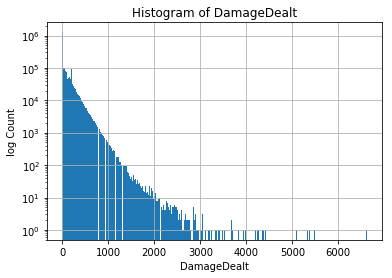

In [21]:
visualize('damageDealt',num_bin=1000)

###### Insight:
* If gamers has very few damage dealt, it means they are killed in short time.

* However, in PUBG, some gamers like to hide in a bush or lie on the floor from begin to end which is very hard to find. These gamers can also have a high ranking. 

* This feature is hard to determine the placement of the gamers.

##### Revives Analysis

Revives means the number of reviving teammates. If a teammate is knoekced down but not killed, player can revive that teammate and the count of reviving will be added one.

Min value of Revives is:  0
Max value of Revives is:  39


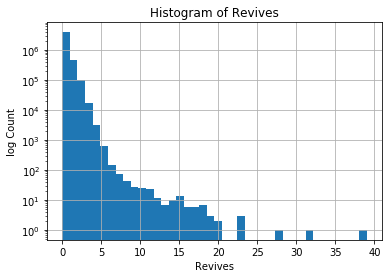

In [22]:
visualize('revives',num_bin=40)

##### Distance Analysis

There are three types of distance value in the given dataset. WalkDistance is the total travelling distance on foot measured in meters. RideDistance is the total travelling distance on vehicles measured in meters. SwimDistance is the total travelling distance by swimming measured in meters.

Min value of WalkDistance is:  0.0
Max value of WalkDistance is:  25776.0


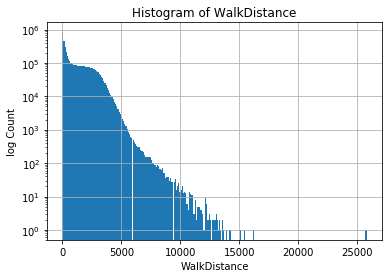

In [23]:
visualize('walkDistance',num_bin=260)

Min value of RideDistance is:  0.0
Max value of RideDistance is:  40704.0


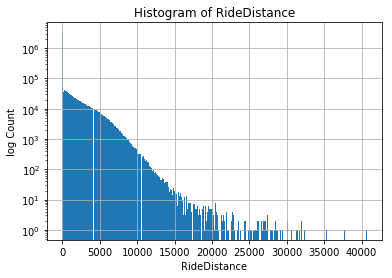

In [24]:
visualize('rideDistance',num_bin=400)

Min value of SwimDistance is:  0.0
Max value of SwimDistance is:  3824.0


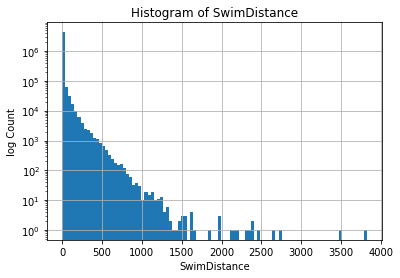

In [25]:
visualize('swimDistance',num_bin=100)

All of the three kinds of distances above can be combined with one feature. 

##### VehicleDestroys Analysis

VehicleDestroys Analysis is the number of vehicles that players destroy. In this game, players are able to destroy vehicles by shooting them or throwing bombs to them.

Min value of VehicleDestroys is:  0
Max value of VehicleDestroys is:  5


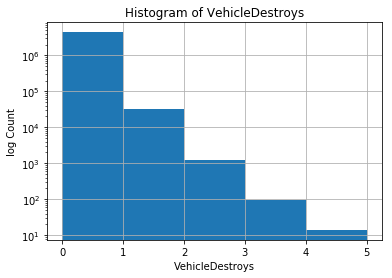

In [26]:
visualize('vehicleDestroys',num_bin=5)

###### Insight:
* Sometimes, destroying the vehicle cannot think as a strong feature to make the prediction, beacuse some gamers like to vandalize the vehicles.

* On the other hand, if the gamers destroy the vehicle that is riding the enemy and cause an explosion, it will bring unexpected kills.

##### Missing Value Analysis

After analyzing the features given in the dataset, checking missing values are also needed.

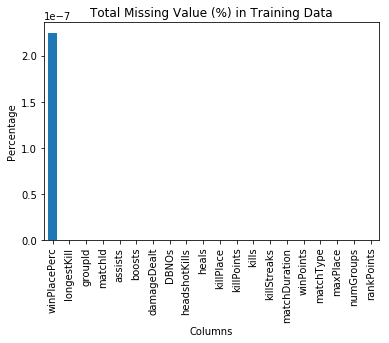

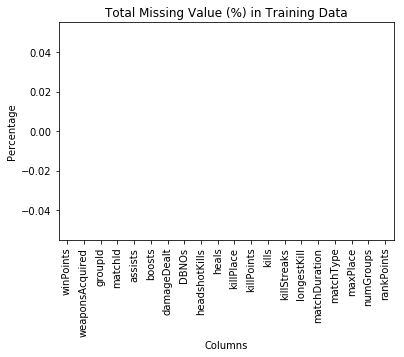

In [27]:
def MissValueAnalysis():
    miss_total = df_train.isnull().sum().sort_values(ascending=False)
    miss_percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([miss_total, miss_percent], axis=1, keys=['total', 'percent'])

    percent_data = miss_percent.head(20)
    percent_data.plot(kind="bar")
    plt.xlabel("Columns")
    plt.ylabel("Percentage")
    plt.title("Total Missing Value (%) in Training Data")
    plt.show()

    miss_total = df_test.isnull().sum().sort_values(ascending=False)
    miss_percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([miss_total, miss_percent], axis=1, keys=['total', 'percent'])

    percent_data = miss_percent.head(20)
    percent_data.plot(kind="bar")
    plt.xlabel("Columns")
    plt.ylabel("Percentage")
    plt.title("Total Missing Value (%) in Training Data")
    plt.show()

MissValueAnalysis()

It could be observed that there is missing value in training data and no missing value in testing data. However, these missing values could be dealt with the statistical behaviour within the group of each match, which will be done during the feature engineering.

##### Coorelation Analysis

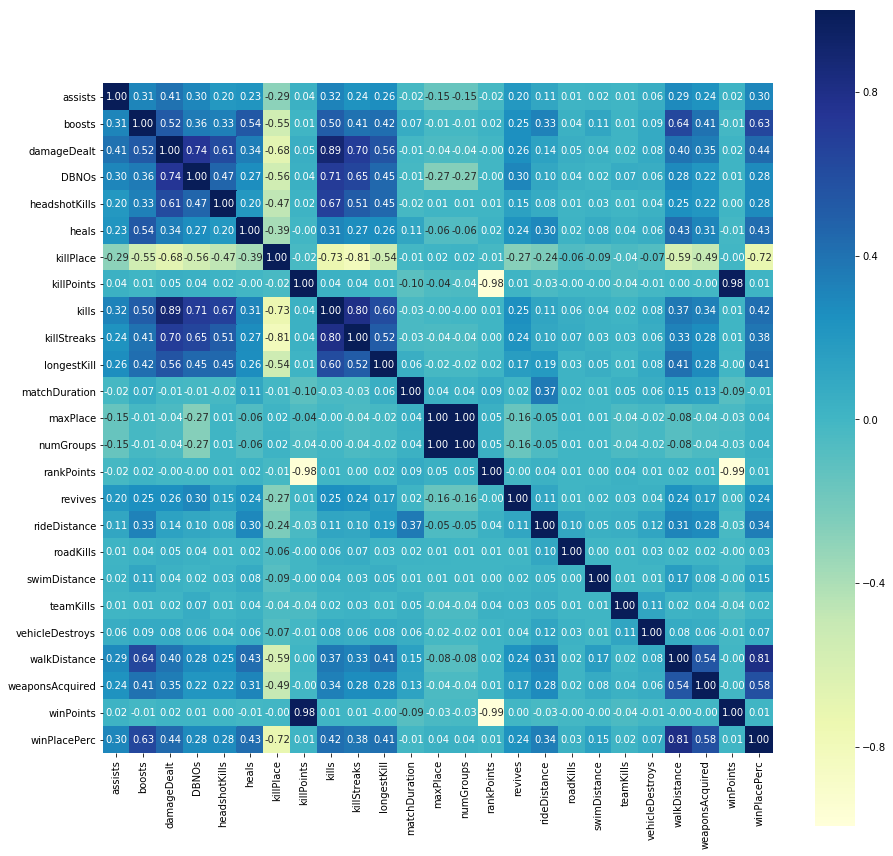

In [28]:
def CorrelationAnalysis():
    corr = df_train.corr()
    f, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(corr,cbar=True, annot=True, 
                          square=True, fmt='.2f', 
                          cmap='YlGnBu')

CorrelationAnalysis()

From correlation heatmap, it could be observed that several features have high correlation with the label winPlacePerc. Let's look at their correlation by visualization.

###### walkDistance vs winPlacePerc

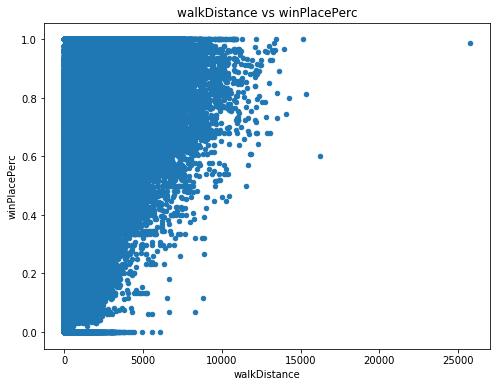

In [29]:
df_train.plot(x="walkDistance",y="winPlacePerc", kind="scatter", figsize=(8,6), title='walkDistance vs winPlacePerc')

It could be observed that higher walkDistance tend to rank higher, which is reasonable since players who died early in the game will not have long walkDistance.

###### heals vs winPlacePerc

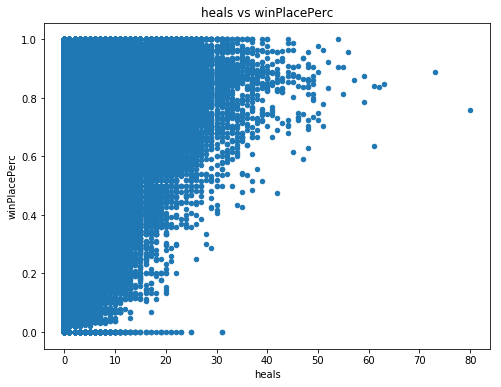

In [30]:
df_train.plot(x="heals",y="winPlacePerc", kind="scatter", figsize=(8,6), title='heals vs winPlacePerc')

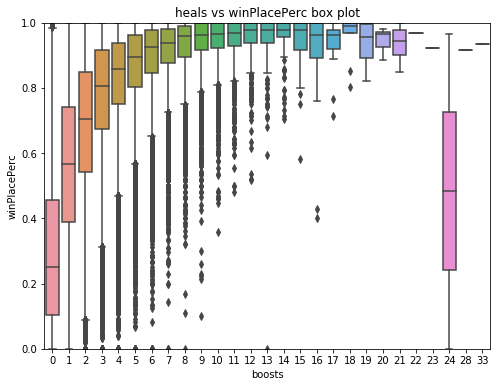

In [31]:
def HealsVSwinPlacePerc():
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sns.boxplot(x='boosts', y="winPlacePerc", data=df_train)
    plt.title('heals vs winPlacePerc box plot')
    fig.axis(ymin=0, ymax=1)

HealsVSwinPlacePerc()

It could be observed that higher value of boosts and heals tend to rank higher, which is reasonable since players who died early in the game will not have chance to use more heal items or boost items.

###### longestKill vs winPlacePerc

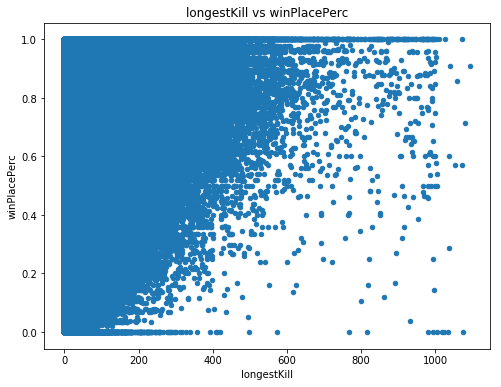

In [32]:
df_train.plot(x="longestKill",y="winPlacePerc", kind="scatter", figsize = (8,6), title='longestKill vs winPlacePerc')

# Feature Engineering

In [0]:
X_train, y_train, train_columns, _ = BuildFeature(is_train=True)
X_test, _, _ , test_idx = BuildFeature(is_train=False)

In [0]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

## Model

#### Attention !!!
This competition on Kaggle is a kernel only competition, submission can only be made in kernels.

Since we cannot train all the models in one jupyter notebook (which will exceed the time limitation for Kaggle kernel), we train these models on the kaggle's kernel seperately.

The training results of the model are taken by screenshoot or duplicate copies and shown under the code of every model.

Corresponded kernel we have committed links for this Kaggle Competition are:

* Linear Regression: https://www.kaggle.com/yansun1996/baseline-linearregression

* Neural Network: https://www.kaggle.com/xufanxiong/artificial-neural-network

* Gradient Boost Regression Tree: https://www.kaggle.com/yansun1996/gbr-ipynb

* LightGBM: https://www.kaggle.com/xufanxiong/light-gbm

### Linear Regression

Linear Regression is a baseline model here just in order to get a basic prediction for this task and get some insights from the prediction.

In [0]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression(n_jobs=4, normalize=True)
LR_model.fit(X_train,y_train)

In [0]:
LR_model.score(X_train,y_train)

In [0]:
y_pred_train = LR_model.predict(X_train)
y_pred_test = LR_model.predict(X_test)

Visualize Prediction Result for training set

In [0]:
y_pred_train[y_pred_train>1] = 1
y_pred_train[y_pred_train<0] = 0

f, ax = plt.subplots(figsize=(10,10))
plt.scatter(y_train, y_pred_train)
plt.xlabel("y")
plt.ylabel("y_pred_train")
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

<img src="FinalRun/LR_prediction.png" alt="Drawing" style="width: 500px;"/>

Submit prediction for testing data

In [0]:
df_test['winPlacePerc'] = y_pred_test
submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('submission_lr.csv', index=False)

The MAE of linear regression model on test set is 0.0445. Since linear regression is a simple model, it had a relatively bad performance. We used this MAE as a baseline.

### Neural Network

Since linear regression model shows a poor performance, we try to find a better method to extract more information from the data. Therefore, we thought of using Neural Network (NN). NN is a computing system imitated from biological neural network. It is a non-linear model, constructed by an input layer, an output layer and some hidden layers. 

In this part, we built a simple NN with 4 hidden layers. The trainin data set is splited into training set and validation set with ratio of 8:2. MSE is used to estimate the model performance on training set and $R^2$ score is used to evaluate the performance on validation set. After 10 epochs, the model has converged.

In [0]:
import warnings
warnings.filterwarnings("ignore")
Xtrain, ytrain, features = featureExtract('train')
Xtest, _, _ = featureExtract('test')

In [0]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(hidden_layer_sizes=(300, 200, 100, 50, ), activation='relu', 
                   solver='adam', alpha=0.0001, batch_size=128,  learning_rate='constant', 
                   learning_rate_init=0.001, max_iter=10, shuffle=True, verbose=True, 
                   early_stopping=True, validation_fraction=0.2)
clf.fit(Xtrain, ytrain) 

Iteration 1, loss = 13.03867796    Validation score: -11.664117

Iteration 2, loss = 0.05291718     Validation score: 0.903167

Iteration 3, loss = 0.02477435     Validation score: -0.000011

Iteration 4, loss = 0.02116714     Validation score: 0.924883

Iteration 5, loss = 0.00290289     Validation score: 0.931118

Iteration 6, loss = 0.00247235     Validation score: 0.952287

Iteration 7, loss = 0.00231838     Validation score: 0.933364

Iteration 8, loss = 0.00225306     Validation score: 0.955590

Iteration 9, loss = 0.00220062     Validation score: 0.950596

Iteration 10, loss = 0.00217747    Validation score: 0.955353

In [0]:
yPred = clf.predict(Xtrain)
yPred[yPred > 1] = 1
yPred[yPred < 0] = 0

In [0]:
plt.figure(figsize=(15, 15))
plt.scatter(ytrain, yPred)
plt.xlabel("y")
plt.ylabel("Predict y")
plt.show()

<img src="FinalRun/NNpred.png" alt="Drawing" style="width: 500px;"/>

Submit prediction for testing data

In [0]:
Xtrain = None
ytrain = None
yPred = clf.predict(Xtest)
yPred[yPred > 1] = 1
yPred[yPred < 0] = 0
df_test['winPlacePerc'] = yPred
submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('submission.csv', index=False)

The MAE of this model on test set is 0.0452. Compared with the linear regression model, NN has a worse performance. This because the architecture of NN we used cannot extract the information efficiently. From Kaggle, some people use NN with 4 hidden layers which has the same size. We thought this model had a worse performance because of the dimensions of hidden layers decreasing rapidly which cannot extract more information. NN should have a better performance if we find a suitable structure.

### Gradient Boost Regression Tree

Gradient Boost Regression Tree has been proved as a correct choice. Compared with the former model we used, GBRT had a smaller MAE because it is an ensemble learning method that trains a collection of weak learners (regression trees) based on the residual of previous weak learner. At last, all the weak learners are collected together to build a strong learner. In this way, the residual error of the weak learners will approache zero by combining these weak learners.

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(loss='ls',learning_rate=0.1,
                                n_estimators=100,max_depth=3)
GBR.fit(X_train,y_train)

```
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
```

In [0]:
GBR.score(X_train,y_train)

0.9602893731164401

In [0]:
y_pred_train = GBR.predict(X_train)
y_pred_test = GBR.predict(X_test)

In [0]:
y_pred_train[y_pred_train>1] = 1
y_pred_train[y_pred_train<0] = 0

f, ax = plt.subplots(figsize=(10,10))
plt.scatter(y_train, y_pred_train)
plt.xlabel("y")
plt.ylabel("y_pred_train")
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

<img src="FinalRun/GBR_prediction.png" alt="Drawing" style="width: 500px;"/>

In [0]:
df_test['winPlacePerc'] = y_pred_test
submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('submission_gbr.csv', index=False)

The MAE of Gradient Boost Regression Tree model on test set is 0.0372.

This result is better than the baseline linear regression model and beat the artificial neural network model.

### Light GBM

Compared with Gradient Boost Regression Tree model, Light GBM is a more powerful and faster model which can use less memory and can get a higher accuracy. Based on traditional GBDT, Light GBM introduces gradient-based one-side sampling method to remove a large portion of the data which has very small gradients. It only use the rest data to estimate the information gain which avoiding the effects of low gradient data. In addition, Light GBM uses exclusive feature bunding method to bind mutually exclusive features to reduce the number of features. At last, since the most time-consuming step is to find the optimal dividing point, light GBM use histogram algorithm to replace the pre-sorted method in traditional GBDT.



In this part, we use 20000 boost trees, 31 leaves which means maximum depth of every boost tree is 5. The model is trained in 20000 epochs. At last, the model is converged. 

In [0]:
import warnings
warnings.filterwarnings("ignore")
Xtrain, ytrain, features = featureExtract('train')
Xtest, _, _ = featureExtract('test')

In [0]:
import lightgbm as lgb

num = Xtrain.shape[0]
splitnum = int(num*0.8)
idx = np.arange(num)
np.random.shuffle(idx)

trainX = Xtrain[idx[:splitnum]]
trainy = ytrain[idx[:splitnum]]
validX = Xtrain[idx[splitnum:]]
validy = ytrain[idx[splitnum:]]
gc.collect()

def lgbModel(trainX, trainy, validX, validy, testX):
    params = {"objective" : "regression", "metric" : "mae", 'n_estimators':20000, 
              'early_stopping_rounds':200, "num_leaves" : 31, "learning_rate" : 0.05, 
              "bagging_fraction" : 0.7, "bagging_seed" : 0, "num_threads" : 4,
              "colsample_bytree" : 0.7
             }
    lgbTrain = lgb.Dataset(trainX, label=trainy)
    lgbVal = lgb.Dataset(validX, label=validy)
    model = lgb.train(params, lgbTrain, valid_sets=[lgbTrain, lgbVal],
                      early_stopping_rounds=200, verbose_eval=1000)
    yPredTest = model.predict(testX, num_iteration=model.best_iteration)
    return yPredTest, model

In [0]:
# Training the model #
yPred, model = lgbModel(trainX, trainy, validX, validy, Xtest)

Training until validation scores don't improve for 200 rounds.

[1000]	training's l1: 0.0282728	valid_1's l1: 0.0287403

[2000]	training's l1: 0.0270548	valid_1's l1: 0.0279181

[3000]	training's l1: 0.0262728	valid_1's l1: 0.0275007

[4000]	training's l1: 0.0256296	valid_1's l1: 0.0272001

[5000]	training's l1: 0.0250872	valid_1's l1: 0.0269874

[6000]	training's l1: 0.0245968	valid_1's l1: 0.0268052

[7000]	training's l1: 0.0241431	valid_1's l1: 0.0266503

[8000]	training's l1: 0.0237278	valid_1's l1: 0.0265211

[9000]	training's l1: 0.0233331	valid_1's l1: 0.0264009

[10000]	training's l1: 0.0229557	valid_1's l1: 0.026291

[11000]	training's l1: 0.0225919	valid_1's l1: 0.0261866

[12000]	training's l1: 0.0222524	valid_1's l1: 0.0260995

[13000]	training's l1: 0.0219172	valid_1's l1: 0.0260056

[14000]	training's l1: 0.0215976	valid_1's l1: 0.0259257

[15000]	training's l1: 0.0212972	valid_1's l1: 0.0258562

[16000]	training's l1: 0.0210015	valid_1's l1: 0.0257848

[17000]	training's l1: 0.0207168	valid_1's l1: 0.0257197

[18000]	training's l1: 0.0204379	valid_1's l1: 0.0256551

[19000]	training's l1: 0.0201651	valid_1's l1: 0.0255966

[20000]	training's l1: 0.0199047	valid_1's l1: 0.0255416

Did not meet early stopping. Best iteration is:

[20000]	training's l1: 0.0199047	valid_1's l1: 0.0255416

In [0]:
df_test = reduceMemory(pd.read_csv('../input/test_V2.csv'))
df_test['winPlacePerc'] = yPred
submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('submission.csv', index=False)

The MAE of LightGBM model on test set is 0.0246, which has the best performance in this project.

## Conclusion

In this project, what we did is to use some datas from PUBG official dataset to predict the the final placement of the gamers in the test set. At first, linear regression was used to  make the predictions. But the MAE of this model was large beacause this is a simple model which cannot extract more information from the data. Hence, non-linear model NN was used to fit the data. Since the architecture of NN we used cannot extract the information from the data efficiently, the performance of NN had no improvements. 

In this case, we introduced more complicated models such as gradient boosting regression tree to improve the performance, which has been proved a correct choice. Compared with the former model we used, GBRT had a smaller MAE because it is an ensemble learning method that trains a collection of weak learners (regression trees) based on the residual of previous weak learner.

At last, all the weak learners are collected together to build a strong learner. In this way, the residual error of the weak learners will approache zero by combining these weak learners. In addition, we also try to use more advanced model to optimize the model based on GBRT. Since LightGBM is a more powerful and faster model because of gradient-based one-side sampling and exclusive feature bunding, we used this model at last. This model had the smallest MAE with 0.0246.